In [14]:
import pandas as pd
import numpy as np

df = pd.read_csv('/Users/balmukundmishra/Desktop/2025-Learning/ML-Course/9_Problem_Statements/data/rare.csv')


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Drop Unnamed index column
df = df.drop(columns=['Unnamed: 0'])

# Convert 'isleak' to integer
df['isleak'] = df['isleak'].astype(int)

# Convert 'time' to datetime (just time, not date)
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S', errors='coerce')

# Map day names to numbers
day_map = {'Mon': 0, 'Tue': 1, 'Wed': 2, 'Thu': 3, 'Fri': 4, 'Sat': 5, 'Sun': 6}
df['day_num'] = df['day'].map(day_map)

# Extract hour and minute as float
df['hour'] = df['time'].dt.hour + df['time'].dt.minute / 60.0

# Cyclical encoding of hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Cyclical encoding of day
df['day_sin'] = np.sin(2 * np.pi * df['day_num'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_num'] / 7)

df['flow_x_duration'] = df['flow_rate'] * df['duration']
df['flow_div_variability'] = df['flow_rate'] / (df['variability'] + 1e-5)  # Avoid divide-by-zero

# Compute mean leak rate per hour
hourly_leak_rate = df.groupby('hour')['isleak'].mean()
df['leak_rate_hour'] = df['hour'].map(hourly_leak_rate)



df['is_night'] = df['hour'].between(0, 6).astype(int)
df['is_peak_hour'] = df['hour'].between(6, 9) | df['hour'].between(17, 21)
df['is_weekend'] = df['day_num'].isin([5, 6]).astype(int)

# Leak likelihood per day
leak_rate_day = df.groupby('day_num')['isleak'].mean()
df['leak_rate_day'] = df['day_num'].map(leak_rate_day)

df['flow_per_second'] = df['flow_rate'] / (df['duration'] + 1e-5)
df['variability_per_sec'] = df['variability'] / (df['duration'] + 1e-5)

df['flow_bin'] = pd.qcut(df['flow_rate'], q=5, labels=False)
df['duration_bin'] = pd.cut(df['duration'], bins=[0, 30, 60, 120, np.inf], labels=False)

df['flow_x_variability'] = df['flow_rate'] * df['variability']
df['duration_x_variability'] = df['duration'] * df['variability']

df['prev_flow'] = df['flow_rate'].shift(1)
df['flow_diff'] = df['flow_rate'] - df['prev_flow']
df['prev_duration'] = df['duration'].shift(1)

df['z_flow_hour'] = df.groupby('hour')['flow_rate'].transform(lambda x: (x - x.mean()) / x.std(ddof=0))
df['z_duration_day'] = df.groupby('day_num')['duration'].transform(lambda x: (x - x.mean()) / x.std(ddof=0))

df['variability_bin'] = pd.qcut(df['variability'], q=4, labels=False)

leak_prob_flow_bin = df.groupby('flow_bin')['isleak'].mean()
df['leak_prob_flow_bin'] = df['flow_bin'].map(leak_prob_flow_bin)

# Drop raw time/day columns
df_model = df.drop(columns=['time', 'day'])

# Separate features and target
X = df_model.drop(columns=['isleak'])
y = df_model['isleak']

# Drop raw time/day columns
df_model = df.drop(columns=['time', 'day'])

# Separate features and target
X = df_model.drop(columns=['isleak'])
y = df_model['isleak']

print("Final features:\n", X.columns.tolist())
print("Target distribution:\n", y.value_counts(normalize=True))

if not isinstance(X, pd.DataFrame):
    X_train_scaled = pd.DataFrame(X)

# Drop columns that contain only zeros
non_zero_cols = X.columns[(X != 0).any()]
X_train_filtered = X[non_zero_cols]

X_train_filtered = X_train_filtered.dropna(axis=1)


# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_train_filtered, y, stratify=y, test_size=0.4, random_state=42
)

# Identify numeric columns for scaling
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_features = []

numeric_transformer = StandardScaler()
one_hencoder = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

smote = SMOTE(k_neighbors=1,random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Confirm balancing
print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", pd.Series(y_train_resampled).value_counts().to_dict())



Final features:
 ['duration', 'flow_rate', 'variability', 'day_num', 'hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'flow_x_duration', 'flow_div_variability', 'leak_rate_hour', 'is_night', 'is_peak_hour', 'is_weekend', 'leak_rate_day', 'flow_per_second', 'variability_per_sec', 'flow_bin', 'duration_bin', 'flow_x_variability', 'duration_x_variability', 'prev_flow', 'flow_diff', 'prev_duration', 'z_flow_hour', 'z_duration_day', 'variability_bin', 'leak_prob_flow_bin']
Target distribution:
 isleak
0    0.99994
1    0.00006
Name: proportion, dtype: float64
Before SMOTE: {0: 29998, 1: 2}
After SMOTE: {0: 29998, 1: 29998}


In [8]:
# from sklearn.ensemble import IsolationForest
# from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
# import numpy as np

# # Use only normal data (no leaks) for training
# X_normal = X_train_scaled[y_train == 0]

# # Train Isolation Forest on normal samples
# iso_forest = IsolationForest(contamination=0.001, random_state=42)
# iso_forest.fit(X_normal)

# # Predict on test data
# y_scores = iso_forest.decision_function(X_test_scaled)
# y_pred_iforest = iso_forest.predict(X_test_scaled)

# # Convert predictions: -1 → anomaly → isleak=1, 1 → normal → isleak=0
# y_pred_iforest = np.where(y_pred_iforest == -1, 1, 0)

# # Evaluate
# print("=== Isolation Forest ===")
# print(confusion_matrix(y_test, y_pred_iforest))
# print(classification_report(y_test, y_pred_iforest, zero_division=0))


In [16]:
from sklearn.svm import OneClassSVM

# Only normal data
X_normal = X_train_scaled[y_train == 0]

# Train
oc_svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.001)
oc_svm.fit(X_normal)

# Predict
y_pred_ocsvm = oc_svm.predict(X_test_scaled)
y_pred_ocsvm = np.where(y_pred_ocsvm == -1, 1, 0)

# Evaluate
print("=== One-Class SVM ===")
print(confusion_matrix(y_test, y_pred_ocsvm))
print(classification_report(y_test, y_pred_ocsvm, zero_division=0))


=== One-Class SVM ===
[[19762   237]
 [    0     1]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19999
           1       0.00      1.00      0.01         1

    accuracy                           0.99     20000
   macro avg       0.50      0.99      0.50     20000
weighted avg       1.00      0.99      0.99     20000



<Axes: xlabel='isleak', ylabel='variability'>

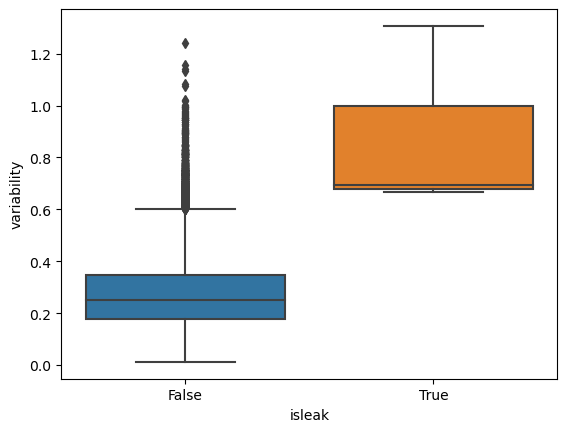

In [12]:
import seaborn as sns
sns.boxplot(data=df, x='isleak', y='variability')

<Axes: xlabel='isleak', ylabel='duration'>

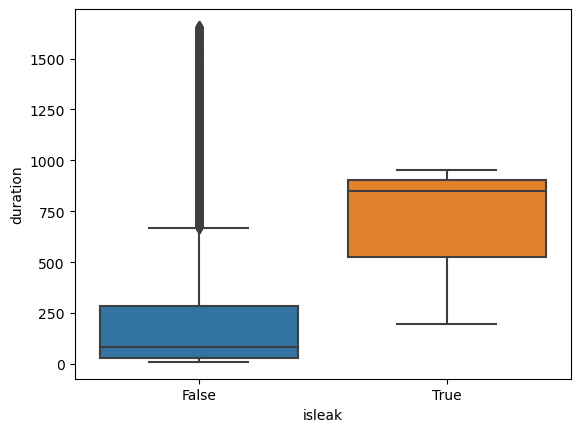

In [13]:
import seaborn as sns
sns.boxplot(data=df, x='isleak', y='duration')

<Axes: xlabel='isleak', ylabel='flow_rate'>

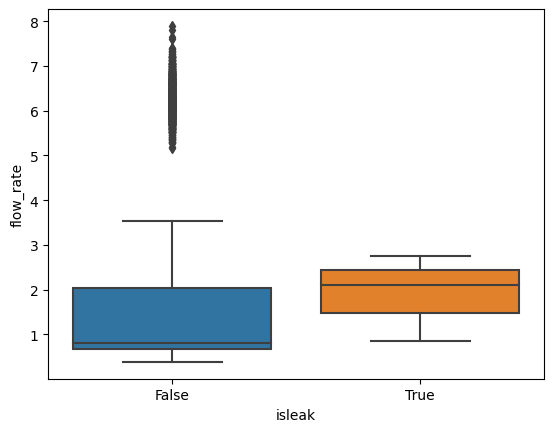

In [14]:
import seaborn as sns
sns.boxplot(data=df, x='isleak', y='flow_rate')

<Axes: xlabel='isleak', ylabel='total_flow'>

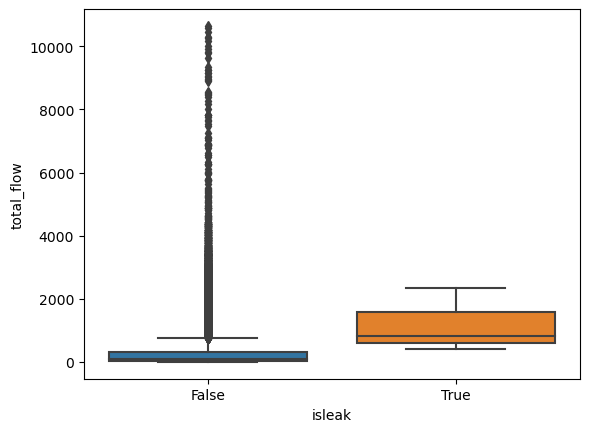

In [15]:
df['total_flow'] = df['duration']*df['flow_rate']
sns.boxplot(data=df, x='isleak', y='total_flow')

<Axes: xlabel='isleak', ylabel='flow_per_variability'>

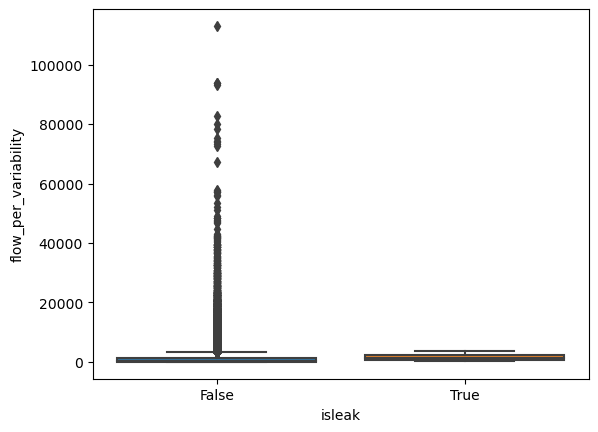

In [16]:
df['flow_per_variability'] = df['total_flow'] / (df['variability'] + 1e-5)
sns.boxplot(data=df, x='isleak', y='flow_per_variability')


<Axes: xlabel='isleak', ylabel='duration_variability_ratio'>

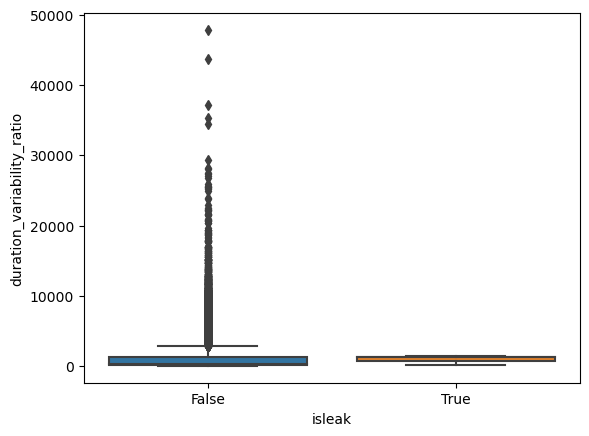

In [17]:
df['duration_variability_ratio'] = df['duration'] / (df['variability'] + 1e-5)
sns.boxplot(data=df, x='isleak', y='duration_variability_ratio')

In [18]:
df['hour'] = pd.to_datetime(df['time']).dt.hour
df['minute'] = pd.to_datetime(df['time']).dt.minute
df['seconds'] = pd.to_datetime(df['time']).dt.second

df = df.drop(columns=['time'])

In [19]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()


,day,duration,flow_rate,variability,isleak,total_flow,flow_per_variability,duration_variability_ratio,hour,minute,seconds
0,Fri,80,0.793672,0.163550,False,63.493751,388.199066,489.117822,4,44,8
1,Sat,174,0.893327,0.300954,False,155.438929,516.469522,578.141506,21,47,41
2,Sun,179,1.971651,0.675501,False,352.925446,522.456994,264.984583,15,52,3
3,Sat,17,1.966782,0.418537,False,33.435300,79.884220,40.616706,13,12,29
4,Wed,33,0.675194,0.131303,False,22.281406,169.682013,251.308491,22,16,24


In [20]:
numerical_features = ['duration', 'flow_rate', 'variability', 'total_flow', 'flow_per_variability', 'duration_variability_ratio']
categorical_features = ['day']

In [21]:
# Preprocessor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
one_hencoder = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [22]:
X = df.drop(columns=['isleak'])
y = df['isleak']

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((40000, 10), (10000, 10))

In [24]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [25]:
X_train

array([[-0.11469106,  0.47213642,  1.20919814, ...,  0.        ,
         1.        ,  0.        ],
       [-0.62890674,  0.30008682, -0.17939847, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.62078686,  0.80089315, -1.08872581, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.65520186, -0.59979032,  0.27392712, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.07735438, -0.66089317, -0.97033855, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.89171766,  0.62964103,  0.60613052, ...,  1.        ,
         0.        ,  0.        ]])

In [26]:
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
model = SVC(gamma='scale')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % scores.mean())

/Users/balmukundmishra/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
/Users/balmukundmishra/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
/Users/balmukundmishra/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/balmukundmishra/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/balmukundmishra/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 399, in _score
    r

Mean ROC AUC: nan


/Users/balmukundmishra/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/balmukundmishra/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/balmukundmishra/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 399, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/Users/balmukundmishra/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_ranking.py", line 572, in roc_auc_score
    return _average_binary_score(
  File "/Users/balmukundmishra/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_base.py", line 75, in _average_binary_score
    return binary_metric(y_true, y_score, sample_weight=sample_weight)
  

In [29]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
models = {
    "support_vector" : SVC(),
    "logistic_regresio" : LogisticRegression(),
    "Random Forest" : RandomForestClassifier(n_estimators= 100, class_weight= "balanced",min_samples_split= 15, max_features= 5, max_depth= 8),
    "Ada Boost" : AdaBoostClassifier(n_estimators= 50, algorithm ='SAMME.R', learning_rate=0.1),
    "Gradient Boosting" : GradientBoostingClassifier(subsample= 0.8, n_estimators = 300, max_depth = 3 , learning_rate=0.01),
    "XGBoost" : XGBClassifier(subsample = 0.8, n_estimators = 100, max_depth = 5,learning_rate = 0.2, colsample_bytree = 1.0)
}

In [33]:
from sklearn.metrics import recall_score, f1_score,roc_auc_score, accuracy_score, confusion_matrix

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred)
    model_train_recall = recall_score(y_train, y_train_pred)
    model_train_f1 = f1_score(y_train, y_train_pred)
    model_train_confusion = confusion_matrix(y_train, y_train_pred)
    #model_train_auc_roc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

    # Test set performance 
    model_test_accuracy = accuracy_score(y_test, y_test_pred)
    model_test_recall = recall_score(y_test, y_test_pred)
    model_test_f1 = f1_score(y_test, y_test_pred)
    #model_test_auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    model_test_confusion = confusion_matrix(y_test, y_test_pred)

    print(list(models.values())[i])
    print("-------------------------------")
    print("Model Performance for train set")
    print("model train accuracy", model_train_accuracy)
    print("Model recall on train set", model_train_recall)
    print("model f1 score on train set", model_train_f1)
    #print("model train auc roc", model_train_auc_roc)
    print("model train confusing matrix", model_train_confusion)
    
    print("--------------------------")
    print("Model performance on Test set")
    print("model test set accuracy", model_test_accuracy)
    print("Test set recall", model_test_recall)
    print("Test set f1", model_test_f1)
    #print("Test set auc roc", model_test_auc_roc)
    print("Test set confusion matrix", model_test_confusion)

SVC()
-------------------------------
Model Performance for train set
model train accuracy 0.99995
Model recall on train set 0.0
model f1 score on train set 0.0
model train confusing matrix [[39998     0]
 [    2     0]]
--------------------------
Model performance on Test set
model test set accuracy 0.9999
Test set recall 0.0
Test set f1 0.0
Test set confusion matrix [[9999    0]
 [   1    0]]
LogisticRegression()
-------------------------------
Model Performance for train set
model train accuracy 0.999975
Model recall on train set 0.5
model f1 score on train set 0.6666666666666666
model train confusing matrix [[39998     0]
 [    1     1]]
--------------------------
Model performance on Test set
model test set accuracy 0.9999
Test set recall 0.0
Test set f1 0.0
Test set confusion matrix [[9999    0]
 [   1    0]]
RandomForestClassifier(class_weight='balanced', max_depth=8, max_features=5,
                       min_samples_split=15)
-------------------------------
Model Performance f